<a href="https://colab.research.google.com/github/ddcreating/RL_code/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 5000
batch_size = 64
replay_buffer_size = 50000
target_update_freq = 10  # Update target network every 10 episodes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
target_net = QNetwork(state_dim, n_actions).to(device)
target_net.load_state_dict(q_net.state_dict())  # Copy weights
target_net.eval()  # Target network is only for inference

optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [4]:
def epsilon_greedy(state, epsilon):
    """
    Select action using epsilon-greedy policy.

    Args:
        state: Current state (numpy array)
        epsilon: Exploration probability

    Returns:
        action: Selected action (int)
    """
    if random.random() < epsilon:
        # Explore: pick a random action
        return random.randint(0, n_actions - 1)
    else:
        # Exploit: pick the best action according to Q-network
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = q_net(state_tensor)
        return q_values.argmax(1).item()

In [5]:
def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    # Compute target: r + gamma * max_a' Q_target(s', a') if not done, else r
    with torch.no_grad():
        next_q_values = target_net(next_states).max(1)[0]
        targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [6]:
## MAIN Loop ##
rewards_dqn = []
steps_to_goal = []

for episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0
    done = False
    steps = 0

    while not done:
        # Select action using epsilon-greedy
        action = epsilon_greedy(state, epsilon)

        # Take action in environment
        next_state, reward, done, truncated, _ = env.step(action)
        done = done or truncated
        steps += 1

        # TODO 2: Store transition in replay buffer
        replay_buffer.append((state, action, reward, next_state, float(done)))

        # Update state and accumulate reward
        state = next_state
        total_reward += reward

        # Train the network
        train_dqn()

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Update target network periodically
    if episode % target_update_freq == 0:
        target_net.load_state_dict(q_net.state_dict())

    # Track metrics
    rewards_dqn.append(total_reward)
    steps_to_goal.append(steps)

    # Print progress
    if episode % 100 == 0:
        avg_reward = np.mean(rewards_dqn[-100:])
        avg_steps = np.mean(steps_to_goal[-100:])
        print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, "
              f"Avg Steps: {avg_steps:.1f}, Epsilon: {epsilon:.3f}")

print("\nTraining completed!")

/tmp/ipython-input-4287730937.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor(states).to(device)


Episode 0, Avg Reward: -200.00, Avg Steps: 200.0, Epsilon: 0.995
Episode 100, Avg Reward: -200.00, Avg Steps: 200.0, Epsilon: 0.603
Episode 200, Avg Reward: -200.00, Avg Steps: 200.0, Epsilon: 0.365
Episode 300, Avg Reward: -200.00, Avg Steps: 200.0, Epsilon: 0.221
Episode 400, Avg Reward: -199.71, Avg Steps: 199.7, Epsilon: 0.134
Episode 500, Avg Reward: -197.42, Avg Steps: 197.4, Epsilon: 0.081
Episode 600, Avg Reward: -176.28, Avg Steps: 176.3, Epsilon: 0.049
Episode 700, Avg Reward: -155.92, Avg Steps: 155.9, Epsilon: 0.030
Episode 800, Avg Reward: -143.20, Avg Steps: 143.2, Epsilon: 0.018
Episode 900, Avg Reward: -133.71, Avg Steps: 133.7, Epsilon: 0.011
Episode 1000, Avg Reward: -134.64, Avg Steps: 134.6, Epsilon: 0.010
Episode 1100, Avg Reward: -136.64, Avg Steps: 136.6, Epsilon: 0.010
Episode 1200, Avg Reward: -141.51, Avg Steps: 141.5, Epsilon: 0.010
Episode 1300, Avg Reward: -139.43, Avg Steps: 139.4, Epsilon: 0.010
Episode 1400, Avg Reward: -149.12, Avg Steps: 149.1, Epsilon

In [7]:
# Evaluation
def evaluate_policy(num_eval_episodes=10):
    """Evaluate the learned policy with greedy action selection."""
    eval_rewards = []
    eval_steps = []

    for _ in range(num_eval_episodes):
        state = env.reset()[0]
        total_reward = 0
        done = False
        steps = 0

        while not done:
            # Greedy action selection (epsilon=0)
            action = epsilon_greedy(state, 0.0)
            state, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            total_reward += reward
            steps += 1

        eval_rewards.append(total_reward)
        eval_steps.append(steps)

    print(f"\nEvaluation Results (over {num_eval_episodes} episodes):")
    print(f"Average Reward: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
    print(f"Average Steps to Goal: {np.mean(eval_steps):.1f} ± {np.std(eval_steps):.1f}")

    return eval_rewards, eval_steps


In [8]:
# Run evaluation
eval_rewards, eval_steps = evaluate_policy(num_eval_episodes=20)


Evaluation Results (over 20 episodes):
Average Reward: -112.40 ± 27.16
Average Steps to Goal: 112.4 ± 27.2


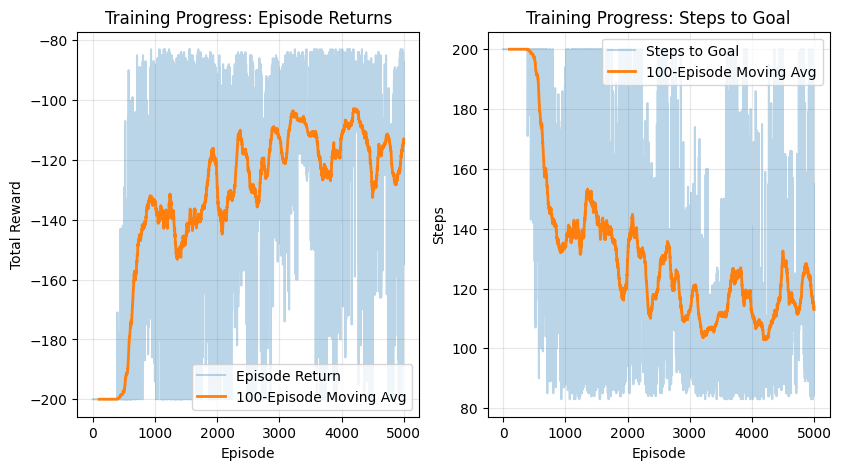

In [9]:
# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Episode vs Return
plt.subplot(1, 3, 1)
plt.plot(rewards_dqn, alpha=0.3, label='Episode Return')
window = 100
moving_avg = np.convolve(rewards_dqn, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(rewards_dqn)), moving_avg,
         label=f'{window}-Episode Moving Avg', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress: Episode Returns')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Steps to Goal
plt.subplot(1, 3, 2)
plt.plot(steps_to_goal, alpha=0.3, label='Steps to Goal')
moving_avg_steps = np.convolve(steps_to_goal, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(steps_to_goal)), moving_avg_steps,
         label=f'{window}-Episode Moving Avg', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Training Progress: Steps to Goal')
plt.legend()
plt.grid(True, alpha=0.3)

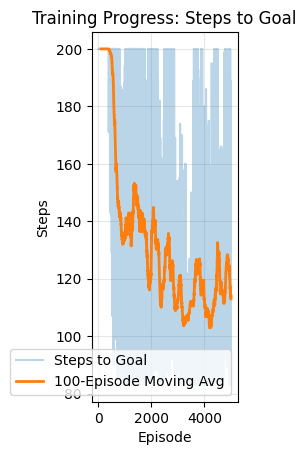

In [12]:
# Plot 2: Steps to Goal
plt.subplot(1, 3, 2)
plt.plot(steps_to_goal, alpha=0.3, label='Steps to Goal')
moving_avg_steps = np.convolve(steps_to_goal, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(steps_to_goal)), moving_avg_steps,
         label=f'{window}-Episode Moving Avg', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Training Progress: Steps to Goal')
plt.legend()
plt.grid(True, alpha=0.3)

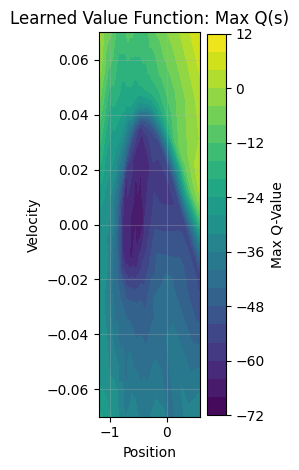

In [11]:
# Plot 3: Value Function Visualization
plt.subplot(1, 3, 3)
positions = np.linspace(-1.2, 0.6, 100)
velocities = np.linspace(-0.07, 0.07, 100)
P, V = np.meshgrid(positions, velocities)
states = np.stack([P.flatten(), V.flatten()], axis=1)

with torch.no_grad():
    states_tensor = torch.FloatTensor(states).to(device)
    q_values = q_net(states_tensor)
    max_q = q_values.max(1)[0].cpu().numpy()

max_q_grid = max_q.reshape(P.shape)
plt.contourf(P, V, max_q_grid, levels=20, cmap='viridis')
plt.colorbar(label='Max Q-Value')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Learned Value Function: Max Q(s)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

env.close()

# Performance of DQN Agent
## Learning Progress
The DQN agent improved from -200 reward initially to stabilizing around -110 by episode 3000. The training shows rapid improvement in the first 1000 episodes, then gradual refinement afterward. The moving average demonstrates consistent learning despite high variance in individual episodes.
## Evaluation Results
Over 20 greedy evaluation episodes:

Average Reward: -112.40 ± 27.16
Average Steps: 112.4 ± 27.2

This represents a 44% improvement over random policy (~200 steps). The agent consistently reached the goal in all episodes, with variance due to different initial states and environment stochasticity.

# Comparison with Tile Coding
## Learning Speed
Tile coding learns faster, typically showing improvement within 200-500 episodes. My DQN took about 1000 episodes for meaningful progress because the neural network must learn representations and values simultaneously, while tile coding directly updates relevant features.
## Stability
Tile coding is more stable with smooth convergence curves. My DQN shows high variance throughout training, with episode returns ranging from -80 to -200 even in later episodes. The moving average oscillates between -105 and -120, indicating less stability than tile coding's typical monotonic improvement.

# Function Approximation and Generalization
Tile coding provides local generalization within overlapping tiles, requires manual feature engineering, is limited to linear relationships, offers high interpretability, and produces blocky value function regions. Neural networks automatically learn features from raw states, capture non-linear patterns, produce global but sometimes unpredictable updates, act as black box representations, and generate smooth value function gradients.
The value function heatmap shows the network learned higher values (yellow) near the goal with positive velocity, demonstrating effective generalization across continuous states.

# Hyperparameter Tuning
The neural network required extensive tuning of 7+ hyperparameters: learning rate (0.001), architecture (2→64→64→3), batch size (64), buffer size (50000), target update frequency (10), epsilon decay (0.995), and discount factor (0.99). Small changes, especially in learning rate, significantly impacted stability.
Tile coding typically needs only 3-4 parameters and is much less sensitive. Default parameters often work acceptably for tile coding, while DQN requires significant experimentation.

#Trade-offs: Hand-Crafted vs Learned Features
Tile coding learns in roughly 500 episodes with high stability and low tuning effort, but scales poorly to high-dimensional problems. Final performance is around 110 steps. DQN requires about 1500 episodes with moderate stability and high tuning effort, but scales well to complex inputs. Final performance is around 112 steps, comparable to tile coding.
For low-dimensional problems where quick results are needed with limited compute resources and interpretability matters, tile coding is preferable. For high-dimensional inputs with complex patterns where scalability is required and time for tuning is available, neural networks are better.
For MountainCar's 2D state space, tile coding is more practical with faster learning, better stability, less tuning, and comparable performance. However, DQN demonstrates valuable automatic feature learning that scales better to complex problems where manual design is difficult. The fundamental trade-off is between injecting domain knowledge for efficiency versus learning flexibility for scalability.

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?
